In [463]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import sympy


import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, plot

import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia as has

# 1 Strain Model

Build SAM and calculate strains

Make the semi-analytic model object.

In [328]:
dur = 10.0*YR
cad = 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
# sam = holo.sam.Semi_Analytic_Model() 
sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hard = holo.hardening.Hard_GW

Calculate strains.

In [329]:
fobs_orb_edges = fobs_edges / 2.0 
fobs_orb_cents = fobs/ 2.0
# edges
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
edges[-1] = fobs_orb_edges
# integrate for number
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges)) 
hc_ss, hc_bg = ss.ss_gws(edges, number, realize=30, 
                                        loudest = 5, params = False) 
print(hc_ss.shape)

17:23:40 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
17:23:40 INFO : Stalled SAM bins based on GMT: 3.20e+03/8.00e+03 = 4.00e-01 [sam.py:static_binary_density]
17:23:40 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
17:23:40 INFO : 	dens bef: (1.28e-114, 1.11e-55, 2.00e-13, 1.79e-03, 1.69e-02, 3.04e-02, 4.47e-02) [sam.py:static_binary_density]
17:23:40 INFO : Scatter added after 0.147277 sec [sam.py:static_binary_density]
17:23:40 INFO : 	dens aft: (6.08e-15, 1.26e-08, 1.91e-06, 1.96e-03, 1.73e-02, 3.03e-02, 4.25e-02) [sam.py:static_binary_density]
17:23:40 INFO : 	mass: 8.91e-02 ==> 8.88e-02 || change = -3.5501e-03 [sam.py:static_binary_density]
17:23:40 INFO : zeroing out 3.20e+03/8.00e+03 = 4.00e-01 systems stalled from GMT [sam.py:static_binary_density]
17:23:40 INFO : fraction of coalesced binaries: 9.44e+03/2.00e+05 = 4.72e-02 [sam.py:dynamic_binary_number]
17:23:40 WARNING : WARNING: _stalled_ binaries are not being ac

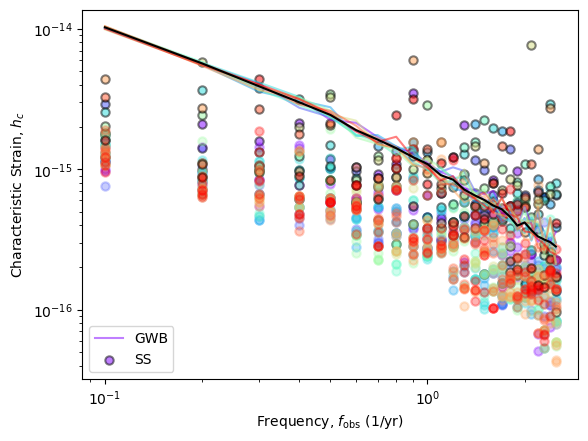

In [385]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_bg = 'GWB'
    else:
        label_bg = None
    plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg, color=colors[rr])
    for ll in range(len(hc_ss[0,0])):
        if ll ==0:
            edgecolor='k'
            alpha_ss = 0.5
            if(rr==0):
                label_ss = 'SS'
            else:
                label_ss = None
        else:
            edgecolor=None
            alpha_ss = 0.3
            label_ss=None
        plt.scatter(fobs*YR, hc_ss[:,rr,ll], alpha=alpha_ss, label=label_ss,
                    color=colors[rr], edgecolors=edgecolor, linewidths=1.5)
plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
plt.legend()


In [ ]:
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# # example 5
# dur = 10.0*YR
# cad = .2*YR

# 2 Pulsar Setup
## 2.1 Make pulsars with hasasia

In [ ]:
num = 20
phis = np.random.uniform(0, 2*np.pi, size = num)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = num)
# sim uses dur in yrs and cad in #/yr
# make list of hasasia.Pulsar objects
pulsars = hsim.sim_pta(timespan = dur/YR, cad = 1/(cad/YR), sigma = 1e-7,
                      phi = phis, theta = thetas)
print(pulsars[0].__dict__.keys())

dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])


In [ ]:
print(thetas)
print(phis)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633]
[3.17920211 2.41674088 5.80005948 0.80000096 3.679069   3.12120041
 3.5479638  4.25533888 3.03048894 6.21145006 5.15137511 0.02039848
 0.03453541 1.70602297 5.15158416 3.01117245 2.89483895 0.78243184
 3.66083075 2.0031836 ]


Make spectra

In [ ]:
spectra = []

for pul in pulsars:
    spec = hsen.Spectrum(pul, freqs=fobs) # spectrum object
    spec.NcalInv # calculate inverse noise weighted transmission function along the way
    spectra.append(spec)
    # add white noise and add red noise here? 
    # add_noise_power(noise)
    # add_red_noise_power(A=None, gamma=None, vals=False)
    # add_white_noise_power(sigma=None, dt = None, vals=False)

## 2.2 Overlap Reduction Function

Using Rosado eq.s:
$$ \Gamma_{ij} = \frac{3}{2} \gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4} \gamma_{ij} + \frac{1}{2} + \frac{1}{2}\delta_{ij} $$
$$ \gamma_{ij} = [1-\cos (\theta_{ij})]/2$$

In [ ]:
def gammaij_from_thetaij(theta_ij):
    """ Calcualte gamma_ij for two pulsars of relative angle theta_ij.
    
    Parameters
    ----------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsars.

    Returns
    -------
    gamma_ij : scalar 
        [1 - cos(theta_ij)]/2

    """
    return (1-np.cos(theta_ij))/2


def dirac_delta(i,j):
    """ Calculate the dirac delta function of i,j.
    Parameters
    ----------
    i : int
    j : int

    Returns
    ------- 
    dirac_ij : int
        Dirac delta function of i and j

    """
    if(i==j): return 1
    else: return 0

def relative_angle(theta_i, phi_i, theta_j, phi_j):
    """ Calculate relative angle between two pulsars i and j.
    
    Parameters
    ----------
    theta_i : scalar 
        Polar angular position in the sky of the ith pulsar.
    phi_i : scalar
        Azimuthal angular position in the sky of the ith pulsar.
    theta_j : scalar 
        Polar angular position in the sky of the jth pulsar.
    phi_j : scalara
        Azimuthal angular position in the sky of the jth pulsar.

    Returns
    -------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsar.

    """
    
    theta_ij = np.arccos(np.cos(phi_i)*np.cos(phi_j) 
                      + np.sin(phi_i)*np.sin(phi_j)*np.cos(theta_i - theta_j))
    
    return theta_ij

def orf_ij(i, j, theta_ij):
    """ Calculate the overlap reduction function Gamma_i,j as a function of theta_i, theta_j, i, and j.
    
    Parameters
    ----------
    i : int
        index of the ith pulsar
    j : int
        index of the jth pulsar
    theta_ij : scalar
        relative angular position between the ith and jth pulsars

    Returns
    -------
    Gamma : scalar
        The overlap reduction function of the ith and jth pulsars.


    Follows Rosado et al. 2015 Eq. (24)
    """
    dirac_ij = dirac_delta(i, j)
    gamma_ij = gammaij_from_thetaij(theta_ij)
    
    Gamma = (3/2 * gamma_ij *np.log(gamma_ij)
            - 1/4 * gamma_ij
            + 1/2 + dirac_ij)
    if(np.isnan(Gamma) and i!=j):
        print('Gamma_%d,%d is nan, set to 0' % (i,j))
        return 0
    return Gamma


def orf_all(pulsars):
    """ Calculate the overlap reduction function matrix Gamma for a list of hasasia.Pulsar objects

    Paramters
    ---------
    pulsars : (P,) list of hasasia.Pulsar objects.

    Returns
    -------
    Gamma : (P,P) NDarray
        Overlap reduction function matrix for all pulsars i,j with j>i
        Only for j>1, 0 for j<=i

    """

    Gamma = np.zeros((len(pulsars), len(pulsars)))
    for ii in range(len(pulsars)):
        for jj in range(len(pulsars)):
            if (jj>ii): # 0 otherwise, allows sum over all
                # calculate angle between two vectors.
                theta_ij =  relative_angle(pulsars[ii].theta, pulsars[ii].phi,
                                           pulsars[jj].theta, pulsars[jj].phi)
                print('theta_ij', theta_ij)
                # find ORF
                Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)
    
    return Gamma


In [ ]:
Gamma = orf_all(pulsars)
print(Gamma)

theta_ij 0.7624612346226041
theta_ij 2.620857369212581
theta_ij 2.37920115120656
theta_ij 0.49986689204396556
theta_ij 0.05800170552600657
theta_ij 0.36876168660067143
theta_ij 1.0761367695422965
theta_ij 0.14871316912419624
theta_ij 3.03224795096947
theta_ij 1.9721729975612492
theta_ij 3.124381674843828
theta_ij 3.1385186077289657
theta_ij 1.4731791411565212
theta_ij 1.9723820485187602
theta_ij 0.16802966192864147
theta_ij 0.2843631573027371
theta_ij 2.396770271986929
theta_ij 0.48162864174725534
theta_ij 1.1760185061487842
theta_ij 2.8998667033444017
theta_ij 1.6167399165839553
theta_ij 1.2623281266665698
theta_ij 0.7044595290965977
theta_ij 1.1312229212232756
theta_ij 1.8385980041649006
theta_ij 0.6137480654984073
theta_ij 2.488476121587513
theta_ij 2.7346342321838533
theta_ij 2.3963423977131537
theta_ij 2.3822054648280226
theta_ij 0.710717906533917
theta_ij 2.7348432831413643
theta_ij 0.5944315726939622
theta_ij 0.47809807731986703
theta_ij 1.634309037364325
theta_ij 1.244089876369

Using hasasia.GWBSensitivityCurve

In [ ]:
scGWB = hsen.GWBSensitivityCurve(spectra) # orf='hd'
print(scGWB.__dict__.keys())
print(scGWB.chiIJ) 

dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ'])
[ 0.05479572  0.17052788  0.09207174  0.22831496  0.49085892  0.32053215
 -0.09236855  0.45557754  0.24627408 -0.05281511  0.24990744  0.24999705
 -0.15142373 -0.05274727  0.44589134  0.37727129  0.09827362  0.2411862
 -0.12092087  0.23198818 -0.13925243 -0.13806522  0.09025201 -0.10927039
 -0.09283283  0.14948219  0.1296003   0.20022365  0.09812323  0.093136
  0.0863265   0.20027277  0.16257825  0.24368081 -0.13670749 -0.13502207
  0.28925409 -0.14115929 -0.00166021  0.18638324  0.04607367 -0.1473445
  0.20813394  0.29077735  0.12619159  0.22573795  0.21579451  0.02303167
  0.12632931  0.21224388  0.23276686 -0.13857191  0.00490012  0.12888399
  0.22880754  0.07127125  0.20331274  0.21994072  0.03815781 -0.0056699
 -0.06563817  0.04473686  0.05301826 -0.02273399 -0.06570309  0.03108342
 -0.01098535  0.49888461  0.22581707 -0.12706838  0.18772382  0.46384043
  0.175015

## 2.3 Noise spectral density $P_i$ 
$$ P_i = 2 \Delta t \sigma_i^2 $$

In [ ]:
def _white_noise(delta_t, sigma_i):
    """ Calculate the white noise for a given pulsar 2 /Delta t sigma_i^2
    
    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigma_i : scalar
        Error/stdev/variance? for the ith pulsar, in seconds.

    Returns
    -------
    P_i : scalar
        Noise spectral density for the ith pulsar, for bg detection.
        For single source detections, the noise spectral density S_i must also 
        include red noise from all but the loudest single sources, S_h,rest. 
        Rosado et al. 2015 Eq. (23)

    """
    P_i = 2 * delta_t * sigma_i**2
    return P_i

In [ ]:
sigmas = np.zeros(num)
for ii in range(num):
    sigmas[ii] = np.mean(pulsars[ii].toaerrs)
noise = _white_noise(cad, sigmas) 
print('P_i =', noise, 's^3 =', noise/YR**3,' yrs^3')

P_i = [1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07] s^3 = [4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30]  yrs^3


# 3 Background Signal
## 3.1 Power Spectral Density
$S_h$, the one-sided power spectral density of the GW signal in the timing residuals
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$

In [ ]:
def power_spectral_density(hc_bg, freqs):
    """ Calculate the spectral density S_h(f_k) ~ S_h0(f_k) at the kth frequency

    Parameters
    ----------
    hc_bg : (F,) 1D array of scalars
        Characteristic strain of the background at each frequency. 
    freqs : (F,) 1Darray of scalars
        Frequency bin centers corresponding to each strain

    Returns
    -------
    S_h : (F,) 1Darray of scalars
        Actual (S_h) or ~construction (S_h0) value of the background spectral density. 
        In units of [freqs]^-3
    """

    S_h = hc_bg**2 / (12 * np.pi**2 * freqs**3)
    return S_h

In [ ]:
Sh_bg = power_spectral_density(hc_bg[:,0], fobs) # spectral density of bg, using 0th realization
Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015
print(Sh_bg)
print(scGWB.S_eff)

[2.75789052e-05 1.22992193e-06 2.28954556e-07 4.31017781e-08
 1.36155074e-08 5.61793205e-09 3.62152561e-09 1.98524105e-09
 6.76660466e-10 3.80936194e-10 9.93923677e-10 1.64709139e-10
 8.71069744e-11 6.46659611e-11 3.18503965e-11 4.61550218e-11
 4.90756718e-11 8.59555027e-12 1.66877639e-11 1.31652118e-11
 5.29527974e-12 3.52880440e-12 6.14033858e-12 1.56824592e-11
 4.95540453e-12]
[2.12394068e-22 2.37290591e-22 4.97357481e-22 8.68267492e-22
 1.34974462e-21 1.94753177e-21 2.68172553e-21 3.64677090e-21
 6.00584985e-21 2.36261682e+09 8.99056593e-21 8.19116954e-21
 9.20977094e-21 1.05246328e-20 1.19993393e-20 1.36014853e-20
 1.53199340e-20 1.71499938e-20 1.90894351e-20 4.29050971e-20
 2.32925468e-20 2.55554585e-20 2.79259041e-20 3.04041256e-20
 3.29905877e-20]


## 3.2 mu_1
$$\mu_1 = 1\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{[P_i + S_{h0}] [P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2} $$


In [ ]:
def mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    mu_1B = 0
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    mu_1B += ((Gamma_ij**2 * Sh * Sh0)
                            /((P_i+Sh0) * (P_j+Sh0) 
                                + Gamma_ij**2 * Sh0**2))
    mu_1B *= 2
    return mu_1B

def mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for jj>ii, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    
    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis] **2 
            * Sh_bg[np.newaxis, np.newaxis, :]
            * Sh0_bg[np.newaxis, np.newaxis, :])
    denom = ((noise[:, np.newaxis, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               * (noise[np.newaxis, :, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis, np.newaxis, :]**2)
    
    # should not need this part if Gamma takes all jj<=ii parts to zero
    sum = np.sum(numer/denom)
    mu_1B = 2*sum
    return mu_1B


In [ ]:
mu_1B_loops = mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(mu_1B_loops, mu_1B)

34.269191650985434 34.269191650985505


## 3.3 sigma_0
$$ \sigma_0^2 = 2\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 P_i P_j  }{\big[ [P_i + S_{h0}] [P_j +S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$



In [ ]:
def sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        
    
    Follows Eq. (A17) from Rosado et al. 2015.
    """

    sigma_0B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh0 = Sh0_bg[kk]
                    numer = Gamma_ij**2 * Sh0**2 * P_i * P_j
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_0B += (numer/denom)
    
    sigma_0B = np.sqrt(2*sigma_0B)
    return sigma_0B


def sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        

    Follows Eq. (A17) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis])
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_0B = np.sqrt(2*sum)
    return sigma_0B



In [ ]:
sigma_0B_loops = sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_0B_loops, sigma_0B)

1.2722914415774633 1.272291441577463


## 3.4 sigma_1
$$ \sigma_1^2 = 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 \big[ [P_i + S_h] [P_j + S_h] + \Gamma_{ij}^2 S_h^2   \big]  }{\big[[P_i + S_{h0}][P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$

In [ ]:
def sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    sigma_1B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    numer = (Gamma_ij**2 * Sh0**2 * 
                             ((P_i + Sh) * (P_j + Sh) 
                              + Gamma_ij**2 * Sh**2))
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_1B += (numer/denom)
    
    sigma_1B = np.sqrt(2*sigma_1B)
    return sigma_1B


def sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * ((noise[:,np.newaxis,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                * (noise[np.newaxis,:,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                + Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2))
             
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_1B = np.sqrt(2*sum)
    return sigma_1B



In [ ]:
sigma_1B_loops = sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_1B_loops, sigma_1B)

5.853989379131588 5.853989379131593


## 3.5 SNR Check
$$S/N_B \equiv \frac{\mu_1}{ \sigma_1} = \Bigg[ 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h^2}{P_iP_j + S_h[P_i + P_j] + S_h^2[1+\Gamma_{ij}^2]}   \Bigg]^{1/2} \quad\quad\quad(\mathrm{A}19)$$

In [ ]:
def SNR_bg_B(noise, Gamma, Sh_bg):
    """ Calculate S/N_B for the background, using P_i, Gamma, S_h and S_h0
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    SNR_B : Scalar
        Signal to noise ratio assuming the B statistic
        

    Follows Eq. (A19) from Rosado et al. 2015.
    """


    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2
    denom = (noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis]
             + Sh_bg[np.newaxis,np.newaxis,:] * (noise[:,np.newaxis,np.newaxis]+noise[np.newaxis,:,np.newaxis])
             + Sh_bg[np.newaxis,np.newaxis,:]**2 * (1 + Gamma[:,:,np.newaxis]**2))

    sum = np.sum(numer/denom)
    SNR_B = np.sqrt(2*sum)
    return SNR_B

    

In [ ]:
SNR_B = SNR_bg_B(noise, Gamma, Sh_bg)
print(SNR_B, mu_1B/sigma_1B)

5.853989379131594 5.853989379131595


compare to hasasia, where they get SNR as a function of $$S_h = \frac{3H_0^2}{2\pi^2} \frac{\Omega_\mathrm{gw}(f)}{f^3}$$ in units of strain^2/Hz, where $\Omega_{gw}=\frac{2\pi^2}{3\;H_0^2}f^3\;S_I$ 

In [ ]:
print(scGWB.Omega_gw.shape)
print(scGWB._H_0.to('Hz'))

(25,)
2.3333610883999426e-18 Hz


In [ ]:
def _Sh_hasasia_generic_bg(scGWB):
    """ Calculate the signal strain power spectral density, 
        `Sh` for hasasia's SNR calculation
        
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    Sh_h : (F,) 1Darray
        Sh as used in hasasia's SNR calculation, for each frequency.
    
    """
    freqs = scGWB.freqs
    H0 = scGWB._H_0.to('Hz').value
    Omega_gw = scGWB.Omega_gw
    Sh_h = 3*H0**2 / (2*np.pi**2) * Omega_gw / freqs**3
    return Sh_h

def SNR_hasasia_generic_bg(scGWB):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    SNR_h : scalar
        Signal to noise ratio from hasasia.
    """
    Sh_h = _Sh_hasasia_generic_bg(scGWB)
    SNR_h = scGWB.SNR(Sh_h)
    return SNR_h
    


In [ ]:
SNR_hg = SNR_hasasia_generic_bg(scGWB)

print(SNR_hg, SNR_B, mu_1B/sigma_1B) # close enough?

6.928203230275508 5.853989379131594 5.853989379131595


We could also use the real characeristic strains with equation (56)
$$h_c(f) \equiv \sqrt{f S_h(f)}$$
$$S_h{f} = h_c(f)^2/f$$

In [ ]:
def _Sh_hasasia_modeled_bg(freqs, hc_bg):
    """ Calculate Sh for hsen.GWBSensitivityCurve.SNR(Sh) from a 
    modeled GWB characteristic strain.
    
    Parameters
    ----------
    freqs : (F,) 1Darray
        Frequencies of char strain.
    hc_bg : (F,R) NDarray
        GWB characteristic strain for each frequency and realization.
    
    Returns
    -------
    Sh_h : (F,R) NDarray
        Sh as used in hasasia's SNR calculation, for each frequency.
    """

    Sh_h = hc_bg**2 / freqs[:,np.newaxis]
    return Sh_h    

def SNR_hasasia_modeled_bg(scGWB, hc_bg):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
    hc_bg : (F,R) NDarray
        Realistic characteristic strain of the background.
        
    Returns
    -------
    SNR_h : (R) 1Darray)
        Signal to noise ratio from hasasia, for each realization.
    """
    Sh_h = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
    SNR_h = np.zeros(len(hc_bg[0]))
    for rr in range(len(hc_bg[0])):
        SNR_h[rr] = scGWB.SNR(Sh_h[:,rr])
    return SNR_h

In [ ]:
SNR_hr = SNR_hasasia_modeled_bg(scGWB, hc_bg)
print(SNR_hr)

[158.46903651 180.20703523 170.4722874  183.79607177 169.1242006
 173.13494595 174.25893294 169.97558354 167.03074702 161.458288
 170.4158636  161.37194598 172.67711781 165.41904668 167.15240822
 177.28558184 174.99773752 161.63829764 156.6942084  170.21084415
 166.46814796 169.79647376 182.46908011 176.68778857 156.59778745
 178.70249187 168.38610189 169.91579587 172.96616683 165.40342701]


compare Sh generic and Sh realistic, these look reasonably close

In [ ]:
Sh_hg = _Sh_hasasia_generic_bg(scGWB)
Sh_hr = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
print(Sh_hg)
print(np.mean(Sh_hr, axis=1))

[2.12394068e-22 2.37290591e-22 4.97357481e-22 8.68267492e-22
 1.34974462e-21 1.94753177e-21 2.68172553e-21 3.64677090e-21
 6.00584985e-21 2.36261682e+09 8.99056593e-21 8.19116954e-21
 9.20977094e-21 1.05246328e-20 1.19993393e-20 1.36014853e-20
 1.53199340e-20 1.71499938e-20 1.90894351e-20 4.29050971e-20
 2.32925468e-20 2.55554585e-20 2.79259041e-20 3.04041256e-20
 3.29905877e-20]
[3.51932488e-20 6.05043557e-21 2.03210246e-21 9.76273485e-22
 4.82385306e-22 2.99554355e-22 1.98980861e-22 1.15730982e-22
 8.60502589e-23 6.00954346e-23 5.01924131e-23 3.50343769e-23
 2.95259477e-23 2.01483234e-23 1.52612207e-23 1.23648401e-23
 1.34478736e-23 7.99991942e-24 9.68412877e-24 7.07506197e-24
 4.69010091e-24 4.30722848e-24 4.37344158e-24 3.59508587e-24
 2.30181964e-24]


most look reasonably close, but no idea why the generic gives a really high Sh at just one frequency.

## 3.6 Detection Probability
$$ \gamma_{bg} = \frac{1}{2} \mathrm{erfc} \big[ \frac{\sqrt{2} \sigma_0 \mathrm{erfc}^{-1}(2\alpha_0) - \mu_1}{\sqrt{2} \sigma_1}\big]

In [ ]:
ALPHA0 = 0.001 # false alarm probability (FAP)

def bg_detection_probability(sigma_0, sigma_1, mu_1, alpha_0):
    """ Calculate the background detection probability, gamma_bg.

    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of stochastic noise processes.
    sigma_1 : scalar
        Standard deviation of GWB PDF.
    mu_1 : scalar
        Mean of GWB PDF.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    dp_bg : scalar
        Background detection probability.

        
    Follows Rosado et al. 2015 Eq. (15)
    """
    temp = ((np.sqrt(2) * sigma_0 * sp.special.erfcinv(2*alpha_0) - mu_1)
            /(np.sqrt(2) * sigma_1))
    dp_bg = .5 * sp.special.erfc(temp)
    return dp_bg

In [ ]:
dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)
print(dp_bg)

0.999999890455621


In [ ]:
def detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg, return_all = False):
    """ Calculate the background detection probability, and all intermediary steps.

    Parameters
    ----------
    THETAS : (P,) 1Darray of scalars
        Latitudinal angular position of each pulsar in radians.
    PHIS: (P,) 1Darray of scalars
        Longitudinal angular position of each pulsar in radians.
    SIGMAS : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    return_all : Bool
        Whether to return all parameters or just dp_bg

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar

    """
    # Overlap Reduction Function
    num = len(THETAS) # number of pulsars, P
    Gamma = np.zeros((num, num)) # (P,P) 2Darray of scalars, Overlap reduction function between all puolsar
    for ii in range(num):
        for jj in range(num):
            theta_ij =  relative_angle(THETAS[ii], PHIS[ii],
                                        THETAS[jj], PHIS[jj])
            # find ORF
            Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)

    # Spectral Density
    Sh_bg = power_spectral_density(hc_bg[:], fobs) # spectral density of bg, using 0th realization
    Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015

    # Noise 
    noise = _white_noise(cad, SIGMAS) 

    mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)

    if(return_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg

# Full Walkthrough

In [ ]:
# # example 5
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# dur = 10.0*YR
# cad = .2*YR

Print Info

In [ ]:
# num_pulsars = 40
# THETAS = np.random.uniform(0.001, 2*np.pi, num_pulsars) # (P,) 1Darray of scalars, angular sky position of each pulsar
# PHIS = np.random.uniform(0.001, np.pi, num_pulsars)
# SIGMAS = np.random.uniform(1e-6, 2e-6, num_pulsars) # (P,) 1Darray of scalars, sigma_i of each pulsar
# ALPHA0 = 0.001
# dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B = \
#     detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg[:,1], return_all=True)
# print('Number of pulsars:',num_pulsars)
# print('\nOVERLAP')
# print('thetas (pi):\t%s' % str(holo.utils.stats(THETAS/np.pi)))
# print('Gamma:\t%s' % str(holo.utils.stats(Gamma)))
# # print('Gamma:\t', Gamma)

# print('\nNOISE')
# print('cadence (s): \t%.2e' % cad)
# print('sigmas (s): %s', str(holo.utils.stats(SIGMAS)))
# print('P_i (s^3):\t%s' % str(holo.utils.stats(noise)))

# print('\nSIGNAL')
# print('fobs (nHz): \t%s' % str(holo.utils.stats(fobs*10**9)))
# print('hc_bg:   \t%s' % str(holo.utils.stats(hc_bg[:,0])))
# print('S_h (s^3):\t%s' % str(holo.utils.stats(Sh_bg)))

# print('\nB STATISTICS')
# print('sigma_0: \t%.2e' % sigma_0B)
# print('sigma_1: \t%.2e' % sigma_1B)
# print('mu_1:    \t%.2e' % mu_1B)

# print('\nDETECTION PROB')
# print('DP_bg:   \t%.2e' % dp_bg)
# print('SNR_B:   \t%.2f' % (mu_1B/sigma_1B))

Compare to hasasia

In [ ]:
# scGWB = hsen.GWBSensitivityCurve(spectra)

In [ ]:
# # print(Sh_bg)
# print('pulsars:', pulsars[0].__dict__.keys())
# print('spectra:', spectra[0].__dict__.keys())
# print('scGWB:', scGWB.__dict__.keys())
# print(scGWB.S_eff)

## detect_bg_pta(pulsars)
can I get cad from pulsar objects?

In [ ]:
# NOTE: Could modify this to take hc_bg[F,R], and return dp[R]

def detect_bg_pta(pulsars, spectra, cad, hc_bg, alpha_0=0.001, ret_all = False):
    """ Calculate the background detection probability, and all the intermediary steps
    from a list of hasasia.Pulsar objects.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    spectra : (P,) list of hasasia.Spectrum objects
        The spectrum for each pulsar.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    alpha_0 : scalar
        Falsa alarm probability
    return_all : Bool
        Whether or not to return intermediate variables.

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar
    """

    # check inputs
    assert len(pulsars) == len(spectra), f"'pulsars ({len(pulsars)}) does not match 'spectra' ({len(spectra)}) !"
    
    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = pulsars[ii].toaerrs

    fobs = spectra[0].freqs

    Gamma = _orf_pta(pulsars)

    Sh_bg = _power_spectral_density(hc_bg[:], fobs)

    white_noise = _white_noise(cad, sigmas)

    mu_1B = _mean1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = _sigma0_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = _sigma1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = _bg_detection_probability(sigma_0B, sigma_1B, mu_1B, alpha_0)

    if(ret_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg
    



In [ ]:
print(spectra[0].toaerrs)

[1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07]


# 4 Single Sources Setup

## 4.1 Place binaries at random positions

(25, 30, 1)


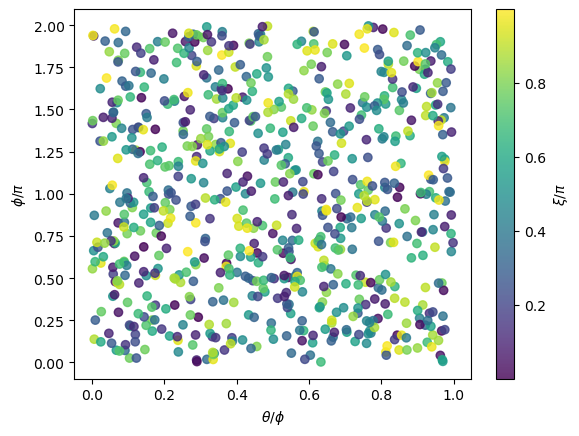

In [ ]:
# shape (F,R,L)
ss_thetas = np.random.uniform(0, np.pi, size = hc_ss[:,:,0].size).reshape(hc_ss.shape)
ss_phis = np.random.uniform(0, 2*np.pi, size = hc_ss[:,:,0].size).reshape(hc_ss.shape)
ss_xis = np.random.uniform(0, np.pi, size = hc_ss[:,:,0].size).reshape(hc_ss.shape)
ss_Phi0s = np.random.uniform(0, 2*np.pi, size = hc_ss[:,:,0].size).reshape(hc_ss.shape)
print(ss_thetas.shape)
plt.scatter(ss_thetas/np.pi, ss_phis/np.pi, c=ss_xis/np.pi, cmap='viridis', alpha=0.8)
plt.xlabel(r'$\theta/\phi$')
plt.ylabel('$\phi/\pi$')
plt.colorbar(label=r'$\xi/\pi$ ')

## 4.2 Unitary vectors

$$\hat{m} = +[\sin (\phi)\cos(\xi) - \sin (\xi) cos(\phi) cos(\theta)] \hat{x} 

- [\cos (\phi) \cos(\xi) + \sin(\xi) \sin(\phi) \cos(\theta)] \hat{y} 

+ [\sin)(\xi)\sin(\phi)]\hat{z} \quad\quad\quad(40)$$

$$ \hat{n} = +[-\sin(\phi) \sin(\xi) - \cos(\xi) \cos(\phi) \cos(\theta)] \hat{x} 
+[\cos(\phi) \sin(\xi) - \cos(\xi) \sin(\phi) \cos(\theta)] \hat{y} 
+[\cos(\xi) \sin(\theta)]\hat{z} \quad\quad\quad(41)$$

$$\hat{\Omega} = -\sin(\theta) \cos(\phi) \hat{x}  - \sin(\theta) \sin(\phi) \hat{y} - \cos(\theta) \hat{z} \quad\quad\quad(42)$$

These are functions of $\theta$ and $\phi$, the angular position of the binary, and $\xi$, the inclination of the binary. 

In [ ]:
def _m_unitary_vector(theta, phi, xi):
    """ Calculate the unitary vector m-hat for the antenna pattern functions.
    
    Parameters
    ----------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    xi : (F,R,L) NDarray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    m_hat : (3,F,R,L) NDarray 
        Unitary vector m-hat with x, y, and z components at 
        index 0, 1, and 2, respectively.
        
    """
    mhat_x = (np.sin(phi) * np.cos(xi) 
              - np.sin(xi) * np.cos(phi) * np.cos(theta))
    mhat_y = -(np.cos(phi) * np.cos(xi)
               + np.sin(xi) * np.sin(phi) * np.cos(theta))
    mhat_z = (np.sin(xi) * np.sin(theta))

    m_hat = np.array([mhat_x, mhat_y, mhat_z])
    return m_hat

def _n_unitary_vector(theta, phi, xi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    xi : (F,R,L) 1Darray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    n_hat : (3,F,R,L) NDarray
        Unitary vector n-hat.
        
    """

    nhat_x = (- np.sin(phi) * np.sin(xi) 
              - np.cos(xi) * np.cos(phi) * np.cos(theta))
    nhat_y = (np.cos(phi) * np.sin(xi) 
              - np.cos(xi) * np.sin(phi) * np.cos(theta))
    nhat_z = np.cos(xi) * np.sin(theta)

    n_hat = np.array([nhat_x, nhat_y, nhat_z])
    return n_hat

def _Omega_unitary_vector(theta, phi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    
    Returns
    -------
    Omega_hat : (3,F,R,L) NDarray
        Unitary vector Omega-hat.
    """

    Omegahat_x = - np.sin(theta) * np.cos(phi)
    Omegahat_y = - np.sin(theta) * np.sin(phi)
    Omegahat_z = - np.cos(theta)

    Omega_hat = np.array([Omegahat_x, Omegahat_y, Omegahat_z])
    return Omega_hat



In [ ]:
m_hat = _m_unitary_vector(ss_thetas, ss_phis, ss_xis)
n_hat = _n_unitary_vector(ss_thetas, ss_phis, ss_xis)
Omega_hat = _Omega_unitary_vector(ss_thetas, ss_phis)
print(m_hat.shape, holo.utils.stats(np.sum(m_hat**2, axis=0)), '\n', 
      n_hat.shape, holo.utils.stats(np.sum(n_hat**2, axis=0)), '\n',  
      Omega_hat.shape, holo.utils.stats(np.sum(Omega_hat**2, axis=0))) # should all be 1
print(m_hat.shape, m_hat[:,0,0,0])
print(n_hat.shape, n_hat[:,0,0,0])
print(Omega_hat.shape, Omega_hat[:,0,0,0])

(3, 25, 30, 1) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00 
 (3, 25, 30, 1) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00 
 (3, 25, 30, 1) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00
(3, 25, 30, 1) [-0.66846736  0.46875716  0.57742368]
(3, 25, 30, 1) [ 0.1586901   0.84839318 -0.50502124]
(3, 25, 30, 1) [-0.72661464 -0.24595879 -0.64151027]


Compare to hasasia, using just the 0th realization
* Omega_hat ($\hat{\Omega}$ in Rosado+2015) -> hsky.K ($\hat{k}$ in Hazboun+2019)
* m_hat ($\hat{m}$ in Rosado+2015) -> hsky L ($\hat{l}$ in Hazboun+2019)
* n_hat ($\hat{n}$ in Rosado+2015) -> hsky M ($\hat{m}$ in Hazboun+2019), -M if we use $\pi - \theta$ for colatitude

In [ ]:
# compare using just the 0th realization, just the loudest source
# thetas_gw = np.pi - ss_thetas[:,0]  # pi - latitude gives colatitude, which reverses the sign of hsky.M
thetas_gw = ss_thetas[:,0,0] 
phis_gw = ss_phis[:,0,0]
print(len(spectra), thetas_gw.shape, phis_gw.shape)
skymap = hsky.SkySensitivity(spectra, thetas_gw, phis_gw)
print('K of 0th freq source:', skymap.K[:,0],
      '\nL of 0th freq source:', skymap.L[:,0], 
      '\nM of 0th freq source:', skymap.M[:,0])
print('\nOmega-hat', Omega_hat[:,0,0,0],
      '\nm-hat:', m_hat[:,0,0,0],
      '\nn-hat', n_hat[:,0,0,0])

20 (25,) (25,)
K of 0th freq source: [-0.72661464 -0.24595879 -0.64151027] 
L of 0th freq source: [ 0.32062855 -0.94720501  0.        ] 
M of 0th freq source: [-0.60764175 -0.20568651  0.76711444]

Omega-hat [-0.72661464 -0.24595879 -0.64151027] 
m-hat: [-0.66846736  0.46875716  0.57742368] 
n-hat [ 0.1586901   0.84839318 -0.50502124]


## 4.3 Pulsar unitary vector
$$ \hat{p}_i = \sin(\theta_i) \cos(\phi_i) \hat{x} + \sin(\theta_i) \sin(\phi_i) \hat{y} + \cos(\theta_i) \hat{z} \quad\quad\quad(43)$$
where $\theta_i$ and $\phi_i$ give the angular position of the ith pulsar.

In [ ]:
def _pi_unitary_vector(phi_i, theta_i):
    """ Calculate the unitary vector p_i-hat for the ith pulsar.
    
    Parameters
    ----------
    phi : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    theta : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    Returns
    -------
    pi_hat : (3,P) vector
        pulsar unitary vector
    
    """

    pihat_x = np.sin(theta_i) * np.cos(phi_i)
    pihat_y = np.sin(theta_i) * np.sin(phi_i)
    pihat_z = np.cos(theta_i)

    pi_hat = np.array([pihat_x, pihat_y, pihat_z])
    return pi_hat

In [ ]:
pi_hat = _pi_unitary_vector(phis, thetas)
print(holo.utils.stats(np.sum(pi_hat**2, axis=1))) # should all be 1
print(pi_hat.shape, pi_hat[:,0])

7.50e-32, 7.50e-32, 7.50e-32, 6.68e+00, 1.33e+01, 1.33e+01, 1.33e+01
(3, 20) [-9.99292848e-01 -3.76005918e-02  6.12323400e-17]


## 4.4 Antenna Pattern Functions
$$ F_i^+ = \frac{1}{2}  \frac{[\hat{m}\cdot \hat{p}_i]^2 - \hat{n} \cdot \hat{p}_i]^2}{1  + \hat{\Omega} \cdot \hat{p}_i} $$
 
 $$ F_i^\times = \frac{\hat{m} \cdot \hat{p}_i] [\hat{n} \cdot \hat{p}_i]}{1 + \hat{\Omega} \cdot \hat{p}_i}

In [ ]:
def dotprod(vec1, vec2):
    """ Calculate the dot product for NDarrays of 3D vectors, with
     vector elements specified by the first index. 
     
     Parameters
     ----------
     vec1 : (3,N1,N2,N3,...N) NDarray
     vec2 : (3,N1,N2,N3,...N) NDarray

     Returns
     -------
     dotted : (N1,N2,N3,...N) NDarray
        The dot product of the vectors specified by the first dimension,
        for every N1, N2, N3,...N.

    Example: find the dot product of 3D vectors for every P,F,R, using NDarrays
    of shape (3,P,F,R)
     """
    
    dotted = vec1[0,...]*vec2[0,...] + vec1[1,...]*vec2[1,...] + vec1[2,...]*vec2[2,...]
    return dotted


def _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat):
    """ + antenna pattern function for the ith pulsar.
    
    Parameters
    ----------
    m_hat : (3,F,R,L) NDarray
        Single source m_hat unitary vector for each frequency and realization.
    n_hat : (3,F,R,L) NDarray
        Single source mnhat unitary vector for each frequency and realization.
    Omega_hat : (3,F,R,L) NDarray
        Single source Omega_hat unitary vector for each frequency and realization.
    pi_hat : (3,P) NDarray
        Pulsar term unitary vector for the ith pulsar.
        
    Returns
    -------
    F_iplus : (P,F,R,L) NDarray
        Plus antenna pattern function for each pulsar and binary of each realization.
    F_icross : (P,F,R,L) NDarray
        Cross antenna pattern function for each pulsar and binary of each realization. 
    
    """
    mh = m_hat[:,np.newaxis,:,:]
    nh = n_hat[:,np.newaxis,:,:]
    Oh = Omega_hat[:,np.newaxis,:,:]
    ph = pi_hat[:,:,np.newaxis,np.newaxis,np.newaxis]
    denom = 1 + dotprod(Oh, ph)
    F_iplus = ((dotprod(mh, ph)**2 - dotprod(nh, ph)**2) 
               / denom / 2)
    F_icross = dotprod(mh, ph) * dotprod(nh, ph) / denom
    
    return F_iplus, F_icross
    

In [ ]:
F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat)
print(F_iplus.shape, holo.utils.stats(F_iplus))
print(F_icross.shape, holo.utils.stats(F_icross))

(20, 25, 30, 1) -9.84e-01, -6.54e-01, -4.19e-01, -5.11e-04, 4.19e-01, 6.52e-01, 9.94e-01
(20, 25, 30, 1) -9.96e-01, -6.52e-01, -4.19e-01, 7.36e-03, 4.32e-01, 6.63e-01, 9.98e-01


Compare to hasasia, using just the 0th realization
* $F_{i,\mathrm{plus}}$ ~> skymap.Fcross
* $F_{i,\mathrm{cross}}$ ~> skymap.Fplus

These don't correspond exactly, but are closeish idk

In [ ]:
print(skymap.Fplus.shape)
print(skymap.Fcross.shape)
# 0th frequency, 0th realization, 0th loudest, all pulsars
print('skymap.Flpus\n', np.sort(skymap.Fplus[:,0]))
print('skymap.Fcross\n', np.sort(skymap.Fcross[:,0]))
# print('skymap.Flong', skymap.Flong)
# print('skymap.Fbreathe', skymap.Fbreathe)


print('F_icross\n', np.sort(F_icross[:,0,0,0]))
print('F_iplus\n', np.sort(F_iplus[:,0,0,0]))


(20, 25)
(20, 25)
skymap.Flpus
 [-0.5554854  -0.53746725 -0.53740961 -0.45516075 -0.34861971 -0.23610266
 -0.09634022 -0.0010791   0.0405418   0.04666044  0.07217201  0.0855895
  0.09987251  0.1025986   0.11405178  0.18576901  0.22129646  0.34036241
  0.52778903  0.55530744]
skymap.Fcross
 [-0.78276154 -0.68625415 -0.68049317 -0.66626354 -0.20021854 -0.17773243
 -0.1504034  -0.14525779 -0.11911746 -0.10091816 -0.07853267 -0.07837593
 -0.06242224  0.02895075  0.0688391   0.07509653  0.14008764  0.2080958
  0.81484376  0.82057318]
F_icross
 [-0.46162778 -0.43169216 -0.32784594 -0.29339801 -0.23308232 -0.11689145
 -0.11085263 -0.10898418 -0.07138679 -0.05566504 -0.02689936 -0.02014994
  0.02473988  0.06776784  0.26066451  0.43614218  0.45941952  0.53188022
  0.5430604   0.5431384 ]
F_iplus
 [-0.78852272 -0.7781128  -0.21907264 -0.21281921 -0.06112655 -0.0545618
 -0.01350344  0.00124791  0.00610558  0.00625325  0.11141797  0.12766821
  0.15017804  0.15446294  0.16699084  0.17600545  0.6280

## 4.5 Amplitude, A

$$ A = 2 \frac{G^{5/3} \mathcal{M}^{5/3} [\pi f [1+z]]^{2/3}}{c^4 r} \quad (5)$$
$ h = A\sqrt{\frac{1}{2}[a^2+b^2]} \quad (4)$ ?? a and b are defined by i, is that related to hc_ss then??
$$ h_s = \frac{8}{10^{1/2}} \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (2\pi f_r)^{2/3}  = \frac{2^{2/3}\times8}{2\times10^{1/2}} \times \big[ 2 \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (\pi f_r)^{2/3} \big] =  \frac{4(2)^{1/6}}{\sqrt{5}} A $$
$$ h_{c,ss}^2 = h_s^2 / dlnf = h_s^2 * f / df $$
$$ h_{c,ss} = h_s \sqrt{f/df} \frac{4(2)^{1/6}}{\sqrt{5}} A * f / df$$
$$ A = \frac{\sqrt{5}}{4 (2)^{1/6}} \sqrt{\frac{df}{f}} h_{c,ss} $$

In [ ]:
def _amplitude(hc_ss, f, df):
    """ Calculate the amplitude from the single source to use in DP calculations
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of each single source at each realization.
    f : (F,) 1Darray
        Frequency
    df : (F,) 1Darray
        Frequency bin widths.

    Returns
    -------
    Amp : (F,R,L)
        Dimensionless amplitude, A, of each single source at each frequency and realization.
    
    """

    Amp = hc_ss * np.sqrt(5) / 4 / 2**(1/6) *np.sqrt(df[:,np.newaxis,np.newaxis]/f[:,np.newaxis,np.newaxis])
    return Amp

In [ ]:
df = np.diff(edges[-1])
amp = _amplitude(hc_ss, fobs, df)
print(amp.shape, holo.utils.stats(amp))

(25, 30, 1) 1.02e-17, 1.44e-17, 3.00e-17, 8.19e-17, 2.90e-16, 6.34e-16, 1.64e-15


## 4.6 ss_noise
Noise from all other sources in the same frequency bin except for the loudest
$$ S_{h,\mathrm{rest}} = \frac{h_{c,\mathrm{rest}}^2}{f} \frac{1}{12 \pi^2 f^2} \quad\quad\quad(45)$$
Included in total noise spectral density for the ith pulsar
$$S_i = 2\Delta t \sigma_i^2 + S_{h,\mathrm{rest}}\quad\quad\quad(44)$$

In [ ]:
def _Sh_rest_noise(hc_ss, hc_bg, freqs):
    """ Calculate the noise spectral density contribution from all but the current single source.

    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain from all loud single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    ss_noise : (F,R,L) NDarray of scalars
        The noise in a single pulsar from other GW sources for detecting each single source.

    Follows Eq. (45) in Rosado et al. 2015.
    TODO: modify this to allow for multiple loud sources.
    """
    hc2_louds = np.sum(hc_ss**2, axis=2) # (F,R) 
    # subtract the single source from rest of loud sources and the background, for each single source
    hc2_rest = hc_bg[:,:,np.newaxis]**2 + hc2_louds[:,:,np.newaxis] - hc_ss**2 # (F,R,L)
    Sh_rest = hc2_rest / freqs[:,np.newaxis,np.newaxis]**3 /(12 * np.pi**2) # (F,R,L)
    return Sh_rest

# otherwise calculate from scratch
def _total_noise(delta_t, sigmas, hc_ss, hc_bg, freqs):
    """ Calculate the noise spectral density of each pulsar, s it pertains to single
    source detections, i.e., including the background as a noise source. 

    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigmas : (P,) 1Darray
        Variance for the ith pulsar, in seconds
    hc_ss : (F,R,L) NDarray
        Characteristic strain from all loud single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    noise : (P,F,R,L) NDarray of scalars
        The total noise in each pulsar for detecting each single source

    Follows Eq. (44) in Rosado et al. 2015.
    """

    noise = _white_noise(delta_t, sigmas) # (P,)
    Sh_rest = _Sh_rest_noise(hc_ss, hc_bg, freqs) # (F,R,L,)
    noise = noise[:,np.newaxis,np.newaxis,np.newaxis] + Sh_rest[np.newaxis,:,:,:] # (P,F,R,L)
    return noise

In [ ]:
tot_noise = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)
print(tot_noise.shape, holo.utils.stats(tot_noise))

(20, 25, 30, 1) 1.26e-07, 1.26e-07, 1.26e-07, 1.26e-07, 1.63e-07, 1.47e-06, 3.17e-05


## 4.7 Polarization contributions
$$ a = 1 + \cos^2 \iota $$
$$ b = -2 \cos \iota $$

Where $\iota$ is the binary inclination angle.

In [ ]:
def _a_b_polarization(iotas):
    """ Polarization contribution variables a and b.
    
    Parameters
    ----------
    iotas : scalar or NDarray
        Typically will be (F,R,L) NDarray

    Returns
    -------
    a_pol : scalar or NDarray
        Same shape as iota
    b_pol : scalar or NDarray
        Same shape as iota

    """
    a_pol = 1 + np.cos(iotas) **2
    b_pol = -2 * np.cos(iotas)
    return a_pol, b_pol

In [ ]:
ss_iotas = ss_xis
a_pol, b_pol = _a_b_polarization(ss_iotas)

## 4.8 GW Phase
$\Phi_0$ is the initial phase and describes the signal detected on Earth. $\Phi(t) = 2\pi f t$, and 
$$\Phi_T = 2 \pi f T \quad\quad\quad (47)$$ 
where $T$ is the duration. 

In [399]:
def _gw_phase(dur, freqs):
    """ Calculate the detected gravitational wave phase at each frequency.

    Parameters
    ----------
    dur : scalar
        Duration (time elapsed from initial phase to detection)
    freqs : (F,) 1Darray
        Frequency of each single source.

    Returns
    -------
    Phi_T : (F,) NDarray
        Detected GW phase of each single source.
    """

    Phi_T = 2 * np.pi * freqs * dur
    return Phi_T

## 4.9 SNR 
### 4.9.1 SNR for a single pulsar
$$ \mathrm{S/N}_i^2 = \frac{A^2}{S_i 8 \pi^3 f^3} \bigg[a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)]
+ \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] \\
+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] \\
- 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) 
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big]\bigg]\quad\quad\quad(46) $$

### 4.9.2 Total SNR (for each single source)
$$\mathrm{S/N_S} = \Big[ \sum_{i=1}^{M} \mathrm{S/N}_i^2\Big]^{1/2} \quad\quad\quad(35)$$

breaking up the SNR_i equation into pieces:
$$ \mathrm{Term 1} = a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)] + \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] $$
$$ \mathrm{Term 2} =+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] $$
$$\mathrm{Term 3} = - 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) \\
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big] $$

$$\mathrm{Coef} =  \frac{A^2}{S_i 8 \pi^3 f^3}$$
$$S/N_i^2 = \mathrm{Coef} \bigg[\mathrm{Term1} + \mathrm{Term2} + \mathrm{Term3}\bigg]$$

In [400]:
def _SNR_ss(amp, F_iplus, F_icross, iotas, dur, Phi_0, S_i, freqs):
    """ Calculate the SNR for each pulsar wrt each single source detection.

    Paramters
    ---------
    amp : (F,R,L) NDarray 
        Dimensionless strain amplitude for loudest source at each frequency.
    F_iplus : (P,F,R,L) NDarray
        Antenna pattern function for each pulsar.
    F_icross : (P,F,R,L) NDarray
        Antenna pattern function for each pulsar.
    iotas : (F,R,L) NDarray
        Is this inclination? or what?
        Gives the wave polarizations a and b.
    dur : scalar
        Duration of observations.
    Phi_0 : (F,R,L) NDarray
        Initial GW Phase.
    S_i : (P,F,R,L) NDarray
        Total noise of each pulsar wrt detection of each single source, in s^3
    freqs : (F,) 1Darray 

    Returns
    -------
    SNR_ss : (F,R,L) NDarray
        SNR from the whole PTA for each single source.

    """
    
    amp = amp[np.newaxis,:,:,:]  # (F,R,L) to (P,F,R,L)
    # print('amp', amp.shape)

    a_pol, b_pol = _a_b_polarization(iotas)
    a_pol = a_pol[np.newaxis,:,:,:] # (F,R,L) to (P,F,R,L)
    b_pol = b_pol[np.newaxis,:,:,:] # (F,R,L) to (P,F,R,L)
    # print('a_pol', a_pol.shape)
    # print('b_pol', b_pol.shape)

    Phi_T = _gw_phase(dur, freqs) # (F,)
    # print('Phi_T', Phi_T.shape)
    Phi_T = Phi_T[np.newaxis,:,np.newaxis,np.newaxis] # (F,) to (P,F,R,L)
    # print('Phi_T', Phi_T.shape)

    Phi_0 = Phi_0[np.newaxis,:,:,:] # (P,F,R,L)
    # print('Phi_0', Phi_0.shape)

    freqs = freqs[np.newaxis,:,np.newaxis,np.newaxis] # (F,) to (P,F,R,L)
    # print('freqs', freqs.shape)

    coef = amp**2 / (S_i * 8 * np.pi**3 * freqs**3) # [S_i] s^3 and [freqs^3] Hz^3 cancel
    
    term1 = a_pol**2 * F_iplus**2 * (Phi_T * (1 + 2 * np.sin(Phi_0)**2) 
                                     + np.cos(Phi_T)*(-np.sin(Phi_T) + 4 * np.sin(Phi_0)) 
                                     - 4*np.sin(Phi_0))
    
    term2 = b_pol**2 * F_icross**2 * (Phi_T*(1+2*np.cos(Phi_0)**2) 
                                      + np.sin(Phi_T)*(np.cos(Phi_T) - 4 * np.cos(Phi_0)))
    
    term3 = - (2*a_pol*b_pol*F_iplus*F_icross 
               * (2*Phi_T*np.sin(Phi_0)*np.cos(Phi_0)
                  + np.sin(Phi_T)*(np.sin(Phi_T) - 2*np.sin(Phi_0) 
                                   + 2*np.cos(Phi_T)*np.cos(Phi_0) 
                                   - 2*np.cos(Phi_0))))
    
    SNR2_pulsar_ss = coef*(term1 + term2 + term3) # (P,F,R,L)

    SNR_ss = np.sqrt(np.sum(SNR2_pulsar_ss, axis=0)) # (F,R,L), sum over the pulsars
    return SNR_ss

In [401]:
SNR_ss = _SNR_ss(amp=amp, F_iplus=F_iplus, F_icross=F_icross, iotas=ss_iotas,
                 dur = dur, Phi_0=ss_Phi0s, S_i=tot_noise, freqs=fobs)
print(SNR_ss.shape, holo.utils.stats(SNR_ss))

(25, 30, 1) 3.44e-03, 7.43e-03, 1.56e-02, 7.52e-02, 5.14e-01, 9.90e-01, 3.00e+00


Compare to hasasia DeterSensitivityCurve.
$$  \rho(\hat{n})=h_0\sqrt{\frac{T_{\rm obs}}{S_{\rm eff}(f_0 ,\hat{k})}} \quad\quad\quad(79) $$ 
from Hazboun et al. 2019.
This might be more comparable to my results if $S_\mathrm{eff}$ is replaced with the noise spectral density that I am using.

Here we use the 0th realization, 0th loudest source

In [402]:
scDeter = hsen.DeterSensitivityCurve(spectra)
rho_h_ss = scDeter.SNR(hc_ss[:,0,0]) 
print(rho_h_ss.shape), holo.utils.stats(rho_h_ss)
print('SNR_ss of 0th realization, 0th loudest source:\n', SNR_ss[:,0,0])
print('SNR using hasasia:', rho_h_ss)

(25,)
SNR_ss of 0th realization, 0th loudest source:
 [0.66085444 0.83057447 2.81214561 0.67643459 0.50113099 0.18659321
 0.19844911 0.14202914 0.11772853 0.20692985 0.16916722 0.07507283
 0.03870073 0.14464299 0.03819697 0.13929604 0.063821   0.02919365
 0.0104046  0.06205911 0.01562588 0.02208689 0.01843654 0.00859032
 0.00552458]
SNR using hasasia: [4.66982830e+00 5.76587956e+00 2.98611757e+00 3.05322059e+00
 1.36068856e+00 9.86878426e-01 7.52562335e-01 7.54141209e-01
 1.87977681e+00 5.69145404e-16 1.98963837e-01 1.96398728e-01
 9.01825904e-01 2.31619697e-01 1.97803310e-01 3.02939994e-01
 1.79007832e-01 1.75761097e-01 2.94178128e-01 1.09320993e-01
 6.87708208e-02 9.92144642e-02 1.57877485e-01 4.21943364e-02
 5.26508818e-02]


## 4.10 Threshold F-statistic $\cal{\bar{F}}_e$ 

Calculated from
$$ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N \quad\quad\quad(31)$$
where $\alpha_0$ is the fixed value false alarm probability and $N$ is the number of single sources (in that realization).

$$ 0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N - \alpha_0 $$
Note, this is the same across all realizations, since it just depends on the number of single sources.

In [506]:
# def _func_Fe_thresh(Fe_bar, Num, alpha_0):
#     # this is only needed for fsolve
#     rv =  1 - (1 - (1 + Fe_bar)*np.exp(-Fe_bar))**Num - alpha_0
#     return rv

# def _Fe_thresh_fsolve(Num, alpha_0=0.001):
#     """ Calculate the threshold F_e statistic using scipy.fsolve.
    
#     Parameters
#     ----------
#     Num : int
#         Number of single sources to detect.
#     alpha_0 : scalar
#         False alarm probability max.

#     Returns
#     -------
#     Fe_bar : scalar
#         Threshold Fe statistic

#     This function doesn't work.
#     """
    
#     Fe_bar = sp.optimize.fsolve(_func_Fe_thresh, 1, args=(Num, alpha_0))[0]
#     return Fe_bar

# import sympy

def _Fe_thresh(Num, alpha_0=0.001):
    """ Calculate the threshold F_e statistic using sympy.nsolve
    
    Parameters
    ----------
    Num : int
        Number of single sources to detect.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    Fe_bar : scalar
        Threshold Fe statistic
    """
    Fe_bar = sympy.Symbol('Fe_bar')
    func = 1 - (1 - (1 + Fe_bar)*np.e**(-Fe_bar))**Num - alpha_0
    Fe_bar = sympy.nsolve(func, Fe_bar, 10)
    return(Fe_bar)

From Wolfram Alpha, Num=25 should give Fe_bar=12.7, Num=125 should give Fe_bar = 14.47 (and many other values particularly -1, complex numbers, and 0)

In [507]:
Num = hc_ss[:,0,:].size # does not depend on realizations
print(Num)
Fe_bar = _Fe_thresh(Num)
print(Fe_bar)

125
14.4747847166094


## 4.11 Detection Probability
### 4.11.1 DP of one single source
$$\gamma_i = \int_{\cal{\bar{F}}_e}^\infty p_1(\cal{F}_e, \rho) d \cal{F}_e \\
= \int_{\cal{\bar{F}}_e}^\infty \frac{[2\cal{F}_e]^{1/2}}{\rho} I_1(\rho\sqrt{2\cal{F}_e}) e^{-\cal{F}_e-\frac{1}{2} \rho^2} d\cal{F}_e$$
with $\rho=\mathrm{S/N_i}$ and $\cal{\bar{F}}_e$ calculated from $ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N$ where $N$ is the number of single sources (in that realization)


I should check this with a test case on Mathematica. On Wolfram alpha I tried: 

integrate sqrt(2* F)/rho * (modified bessel function of the first kind(rho * sqrt(2*F))) * exp(-F - 1/2 rho^2) dF from 14.47 to infinity for rho=0.66085444,

or

integrate sqrt(2*F)/0.66085444 * (modified bessel first kind(0.66085444 * sqrt(2*F))) * exp(-F - 1/2 *0.66085444^2) dF from 14.47 to infinity 

but this timed out. Need to try mathematica instead.

In [498]:
def _integrand_gamma_ss_i(Fe, rho):

    I_1 = sp.special.i1(rho*np.sqrt(2*Fe))
    rv = (2*Fe)**(1/2) /rho * I_1 * np.exp(-Fe - rho**2 /2)
    return rv

def _gamma_ssi(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,L) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ssi : (F,R,L) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for-loops.
    """
    gamma_ssi = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            for ll in range(len(rho[0,0])):
                gamma_ssi[ff,rr,ll] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr,ll]))[0]
                if(np.isnan(gamma_ssi[ff,rr,ll])):
                    print(f'gamma_ssi[{ff},{rr},{ll}] is nan, setting to 0.')
                    gamma_ssi[ff,rr,ll] = 0
   

    return gamma_ssi


def _gamma_ssi(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,L) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ssi : (F,R,L) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for loops!
    """
    gamma_ssi = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            for ll in range(len(rho[0,0])):
                gamma_ssi[ff,rr,ll] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr,ll]))[0]
                if(np.isnan(gamma_ssi[ff,rr,ll])):
                    print(f'gamma_ssi[{ff},{rr},{ll}] is nan, setting to 0.')
                    gamma_ssi[ff,rr,ll] = 0
   

    return gamma_ssi



In [499]:
gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss)
print(gamma_ssi.shape, holo.utils.stats(gamma_ssi))
print(gamma_ssi.shape, gamma_ssi[:,0,0]) 

(25, 30, 1) 8.00e-06, 8.01e-06, 8.01e-06, 8.16e-06, 1.72e-05, 7.03e-05, 2.25e-02
(25, 30, 1) [2.56666585e-05 4.26727767e-05 1.43962906e-02 2.68507504e-05
 1.66056991e-05 8.97906719e-06 9.11170816e-06 8.56110503e-06
 8.38447082e-06 9.21234528e-06 8.80073335e-06 8.15748360e-06
 8.04460436e-06 8.58221296e-06 8.04355190e-06 8.53947677e-06
 8.11474936e-06 8.02707760e-06 8.00690209e-06 8.10869502e-06
 8.01058550e-06 8.01719148e-06 8.01318070e-06 8.00596827e-06
 8.00479580e-06]


Try using the hasasia SNR's instead

In [505]:
# print(rho_h_ss.shape, rho_h_ss)
gamma_ssi_h = _gamma_ssi(Fe_bar=Fe_bar, rho=rho_h_ss[:,np.newaxis,np.newaxis])
print(gamma_ssi_h.shape, gamma_ssi_h.squeeze())


gamma_ssi[1,0,0] is nan, setting to 0.
(25, 1, 1) [3.40983771e-01 0.00000000e+00 2.15585094e-02 2.50436512e-02
 2.31105591e-04 6.97014973e-05 3.36378220e-05 3.37980485e-05
 1.15999536e-03 8.00396889e-06 9.11767825e-06 9.08810261e-06
 5.32719279e-05 9.53351538e-06 9.10424296e-06 1.07162904e-05
 8.89903752e-06 8.86591928e-06 1.05491131e-05 8.33146772e-06
 8.13268019e-06 8.27317143e-06 8.69550094e-06 8.05228508e-06
 8.07927103e-06]


Why do I have one random nan value??

### 4.11.2 Detection Probability of any single source
$$\gamma_{ss} = 1 - \prod_{i}[1-\gamma_i]$$

In [501]:
def _ss_detection_probability(gamma_ss_i):
    """ Calculate the probability of detecting any single source, given individual single 
    source detection probabilities.
    
    
    Parameters
    ----------
    gamma_ss_i : (F,R,L) NDarray
        Detection probability of each single source, at each frequency and realization.

    Returns
    -------
    gamma_ss : (R) 1Darray
        Detection probability of any single source, for each realization
    """
    
    gamma_ss = 1 - np.product(1-gamma_ss_i, axis=(0,2))
    return gamma_ss

In [502]:
gamma_ss = _ss_detection_probability(gamma_ss_i)
print(gamma_ss.shape, holo.utils.stats(gamma_ss))
print(gamma_ss.squeeze())

(30,) 2.88e-04, 2.89e-04, 3.05e-04, 5.38e-04, 3.37e-03, 1.47e-02, 2.31e-02
[0.01467077 0.00293551 0.00088615 0.0003248  0.02308198 0.00029787
 0.00034113 0.00043364 0.00749233 0.00050772 0.00030046 0.00043328
 0.0073582  0.00045809 0.00028824 0.00109076 0.00099931 0.00171562
 0.00029363 0.00160476 0.00051265 0.00036334 0.00056304 0.00064926
 0.0003454  0.00031854 0.00028853 0.00351843 0.00211146 0.00160727]


In [504]:
gamma_ss_h = _ss_detection_probability(gamma_ssi_h)
print(gamma_ss_h.shape, gamma_ss_h)

(1,) [0.37241719]


Several binaries have hasasia SNR's about an order of magnitude higher than the SNR's we calculated. That order of magnitude makes a big difference in the total detection probability!

In [ ]:
def detect_ss(thetas, phis, sigmas, cad, dur, 
              fobs, dfobs, hc_ss, hc_bg, alpha_0=0.001, ret_all=False,
              theta_ss=None, phi_ss=None, iota_ss=None, xi_ss=None, Phi0_ss=None):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    thetas : (P,) 1Darray of scalars
        Polar (latitudinal) angular position of each pulsar in radians.
    phis : (P,) 1Darray of scalars
        Azimuthal (longitudinal) angular position of each pulsar in radians.
    sigmas : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    xi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """

    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if xi_ss is None:
        xi_ss = iota_ss # edit this when I figure out what xi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)
    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)
    
    # noise spectral density
    S_i = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)

    # amplitudw
    amp = _amplitude(hc_ss, fobs, dfobs) # (F,R,L)

    # SNR (includes a_pol, b_pol, and Phi_T calculations internally)
    SNR_ss = _SNR_ss(amp, F_iplus, F_icross, iota_ss, dur, Phi0_ss, S_i, fobs) # (F,R,L)
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



In [ ]:


def detect_ss_pta(pulsars, cad, dur, 
              dfobs, hc_ss, hc_bg, alpha_0=0.001, ret_all=False):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    spectra : (P,) list of hasasia.Spectrum objects
        The spectrum for each pulsar.
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    xi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """
    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if xi_ss is None:
        xi_ss = iota_ss # edit this when I figure out what xi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)


    # check pulsar inputs
    assert len(pulsars) == len(spectra), f"'pulsars ({len(pulsars)}) does not match 'spectra' ({len(spectra)}) !"
    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = np.mean(pulsars[ii].toaerrs)

    fobs = spectra[0].freqs
    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)
    
    # noise spectral density
    S_i = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)

    # amplitudw
    amp = _amplitude(hc_ss, fobs, dfobs) # (F,R,L)

    # SNR (includes a_pol, b_pol, and Phi_T calculations internally)
    SNR_ss = _SNR_ss(amp, F_iplus, F_icross, iota_ss, dur, Phi0_ss, S_i, fobs) # (F,R,L)
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



I should also compare S_i to hasasia?